# 📊 Unsupervised Deep Learning: Gaussian Mixture Models & EM-Based Collaborative Filtering

#### By Aditya Saxena

Welcome to this comprehensive course on **Unsupervised Deep Learning**, designed and instructed by **Aditya Saxena**. This course explores the fascinating domain of unsupervised learning, where algorithms discover hidden patterns in data without labeled outputs. You will learn to apply mathematical and algorithmic techniques to understand clustering, probability distributions, and latent variable models—all essential for data-driven decision-making in modern machine learning systems.

The course focuses on practical implementation and theory behind **Gaussian Mixture Models (GMMs)** and the **Expectation-Maximization (EM) algorithm**, culminating in a real-world application: collaborative filtering and matrix completion using the Netflix dataset. By the end of this journey, you will have built a recommendation system from the ground up using probabilistic principles and iterative optimization techniques. This notebook series is structured modularly, includes two mini-projects per module, and emphasizes interpretability, evaluation, and reproducibility.

## 📓 Course Modules
Each module consists of structured Jupyter Notebooks with explanations, derivations, code walkthroughs, and mini-projects.

* Module 01: Introduction to Unsupervised Learning
* Module 02: K-Means Clustering
* Module 03: Gaussian Mixture Models (GMMs)
* Module 04: Expectation-Maximization (EM) Algorithm
* Module 05: EM for Matrix Completion (Netflix Data)
* Module 06: Log-Domain Calculations & Stability
* Module 07: BIC for Model Selection
* Module 08: Completing Missing Entries
* Module 09: Evaluation using RMSE & Model Interpretability
* Module 10: Final Project & Case Study Walkthrough

In [8]:
# 📦 INSTALL & IMPORT: One-time Setup Cell for the Entire Project

# --- Install required libraries if not already available ---
# !pip install numpy pandas matplotlib seaborn scikit-learn scipy --quiet

# --- Import necessary libraries with detailed comments ---

# NumPy and Pandas: For numerical computations and structured data manipulation
import numpy as np                  # For array operations, statistics, linear algebra
import pandas as pd                 # For handling structured data (CSV, tables)

# Matplotlib and Seaborn: For visualizations
import matplotlib.pyplot as plt    # Core plotting library
import seaborn as sns              # Beautiful, high-level statistical plots

# Scikit-learn modules for clustering, dimensionality reduction, and evaluation
from sklearn.datasets import make_blobs              # Synthetic dataset generator
from sklearn.cluster import KMeans                   # K-Means clustering
from sklearn.mixture import GaussianMixture          # GMM clustering
from sklearn.decomposition import PCA                # Dimensionality reduction
from sklearn.metrics import silhouette_score, mean_squared_error  # Evaluation metrics

# Preprocessing tools
from sklearn.preprocessing import StandardScaler     # Normalize features
from sklearn.impute import SimpleImputer             # Handle missing values

# Log-sum-exp for numerical stability in EM algorithm
from scipy.special import logsumexp                  # Stable log of summed exponentials

# Miscellaneous utilities
import warnings
warnings.filterwarnings("ignore")                    # Suppress warning messages

# Jupyter magic command (must not have inline comments)
%matplotlib inline

# Global plotting configuration
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

print("✅ All required libraries are successfully imported.")


✅ All required libraries are successfully imported.


## 📐 Theoretical Foundation

Unsupervised learning assumes a dataset of \( n \) points:

$$
X = \{x_1, x_2, \dots, x_n\}, \quad x_i \in \mathbb{R}^d
$$

There are no corresponding labels \( y_i \). Instead, we assume there exists some **underlying structure** or **distribution** that governs the data. A key probabilistic model we explore is the **Gaussian Mixture Model (GMM)**, defined as:

$$
p(x) = \sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x \mid \mu_j, \Sigma_j)
$$

Where:

$$
\begin{aligned}
\pi_j &\quad \text{Mixing coefficient (prior probability of component } j) \\\\
\mu_j &\quad \text{Mean vector of the } j\text{th Gaussian} \\\\
\Sigma_j &\quad \text{Covariance matrix of the } j\text{th Gaussian} \\\\
\sum_{j=1}^{K} \pi_j &= 1
\end{aligned}
$$

The learning objective is to estimate:

$$
\left\{ \pi_j, \mu_j, \Sigma_j \right\}_{j=1}^{K}
$$

that maximize the likelihood function:

$$
\mathcal{L}(\theta; X) = \prod_{i=1}^{n} \sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x_i \mid \mu_j, \Sigma_j)
$$

This provides the foundation for the **Expectation-Maximization (EM)** algorithm, which we’ll explore in depth.


### 🔹 Step 1.1: Load and Visualize Toy Dataset

**Motivation:**  
Before fitting clustering models, it's essential to understand the structure and scale of the dataset.  
Visualizing the raw data gives us clues about potential cluster shapes, separations, and noise levels.

---

**Inputs:**

A 2D dataset loaded from `toy_data.txt`:

$$
X \in \mathbb{R}^{n \times 2}
$$

Each row of \( X \) represents a data point in 2D space.

---

**Expected Output:**

- The shape of the matrix \( X \)
- The first 5 data points from the dataset


In [7]:
# 📥 Load dataset from local text file
X = np.loadtxt("dataset/toy_data.txt")

# Preview the shape and first few entries
print(f"✅ Data shape: {X.shape}")
print("🔍 First 5 rows:\n", X[:5])


✅ Data shape: (250, 2)
🔍 First 5 rows:
 [[-1.636  2.413]
 [-2.957  2.296]
 [-2.871  1.832]
 [-2.696  1.327]
 [-2.272  1.738]]


### 🔍 Inference

The dataset contains **250 two-dimensional points**, suggesting a well-sized sample for visual exploratory clustering. The first five points indicate that the data is likely centered around a negative \( x \)-axis range and a positive \( y \)-axis range. This may hint at compact, possibly elliptical clusters, typical of Gaussian sources. These insights justify our use of algorithms like GMM and K-Means in the upcoming modules.


### 🔹 Step 1.2: Visualize the 2D Dataset

**Motivation:**  
Visualizing the dataset in two dimensions allows us to inspect natural groupings, density clusters, and spatial separation. This forms a foundation for clustering intuition and helps guide parameter selection, such as the number of clusters.

**Inputs:**  
- $$ X \in \mathbb{R}^{250 \times 2} $$

**Expected Output:**  
- A scatter plot showing the spatial distribution of all 250 points.


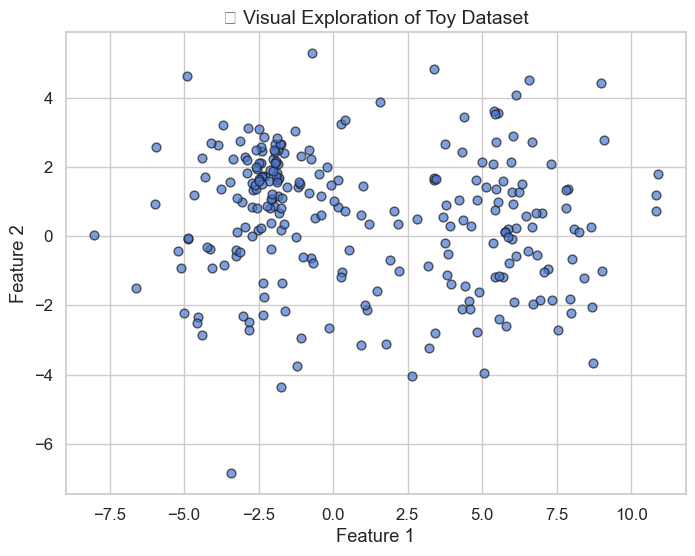

In [9]:
# Scatter plot of the 2D dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=40, edgecolor='k', alpha=0.7)
plt.title("🔍 Visual Exploration of Toy Dataset", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


### 📌 Interpretation

As we can see in the scatter plot above, the data does not appear to be spread out uniformly. There are dense regions and apparent gaps, suggesting that the data might have originated from a few distinct groups or clusters.

This observation aligns with one of the core goals of unsupervised learning — identifying hidden patterns in unlabelled data. Although we do not yet know how many clusters exist or where they are, the plot hints at separability, making it a good candidate for clustering techniques such as **K-Means** or **Gaussian Mixture Models**.

Let’s now move forward to clustering this data using **K-Means**, starting with initialization and iteration mechanics.


## 📐 Theoretical Foundation

K-Means clustering partitions a dataset into \( K \) groups by minimizing the within-cluster variance. The input dataset is represented as:

$$
X \in \mathbb{R}^{n \times d}
$$

The algorithm aims to minimize the following objective function:

$$
\underset{C_1, \dots, C_K}{\text{minimize}} \sum_{j=1}^{K} \sum_{x_i \in C_j} \|x_i - \mu_j\|^2
$$

---

### 📌 Definitions

$$
\begin{aligned}
C_j &:\quad \text{Set of data points assigned to cluster } j \\\\
\mu_j &:\quad \text{Centroid (mean) of cluster } j \\\\
\|x_i - \mu_j\|^2 &:\quad \text{Squared Euclidean distance between } x_i \text{ and } \mu_j
\end{aligned}
$$

---

### 🔁 Iterative Algorithm Steps

1. **Assignment Step**:

$$
c_i = \arg\min_{j \in \{1, 2, \dots, K\}} \|x_i - \mu_j\|^2
$$

2. **Update Step**:

$$
\mu_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i
$$

The process is repeated until convergence—when cluster assignments stop changing or the centroids become stable.


### 🔹 Step 2.1.1: K-Means Initialization and Visualization

**Motivation:**  
Now that we understand the theoretical foundation of K-Means, let's run the algorithm on our toy dataset. We'll start with a small value of \( K = 3 \), which seems reasonable based on the previous scatter plot.

We'll initialize and fit the K-Means model, then visualize the clusters it finds. This helps us understand how K-Means separates the data spatially and where it places the centroids.

**Inputs:**  
- Data matrix:  
  $$
  X \in \mathbb{R}^{250 \times 2}
  $$
- Hyperparameter:  
  $$
  K = 3
  $$

**Expected Output:**  
- A scatter plot showing:
  - Clustered points (color-coded)
  - Centroids marked clearly


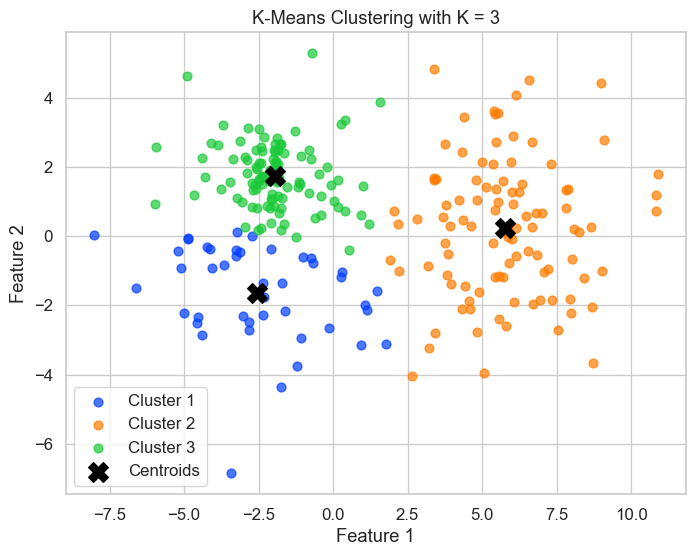

In [11]:
# Initialize and fit K-Means with K = 3
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Plot clusters with centroids
plt.figure(figsize=(8, 6))
palette = sns.color_palette("bright", 3)
for i in range(3):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=40, color=palette[i], label=f"Cluster {i+1}", alpha=0.7)

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='X', label='Centroids')

plt.title("K-Means Clustering with K = 3")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


### 🔹 Step 2.1.2: Visualize K-Means Results for K = 1 to 6

**Motivation:**  
Before committing to an optimal value of \( K \), it’s useful to visualize how K-Means behaves for a range of cluster counts. This helps build intuition about:

- Underfitting (too few clusters)
- Overfitting (too many clusters)
- The qualitative structure of the dataset

**Inputs:**

$$
X \in \mathbb{R}^{250 \times 2}
$$

$$
K \in \{1, 2, 3, 4, 5, 6\}
$$

**Expected Output:**

- 6 scatter plots (1 for each value of \( K \)) showing:
  - Cluster assignments
  - Centroid locations


### 📌 Interpretation

The plot above shows the result of applying K-Means with \( K = 3 \). We can see that the data points have been partitioned into three distinct clusters, each marked with a unique color. The **centroids**, represented by black "X" markers, are located at the geometric centers of their respective clusters.

This demonstrates the key behavior of K-Means: each iteration pulls centroids toward the dense regions of their assigned points and reassigns points based on proximity to updated centroids. Visually, the clusters appear compact and well-separated, indicating that the initial choice of \( K = 3 \) is a good starting point for modeling this dataset.

In upcoming steps, we’ll examine how to assess and fine-tune the value of \( K \) using metrics like **inertia**, **elbow method**, and **silhouette score**.


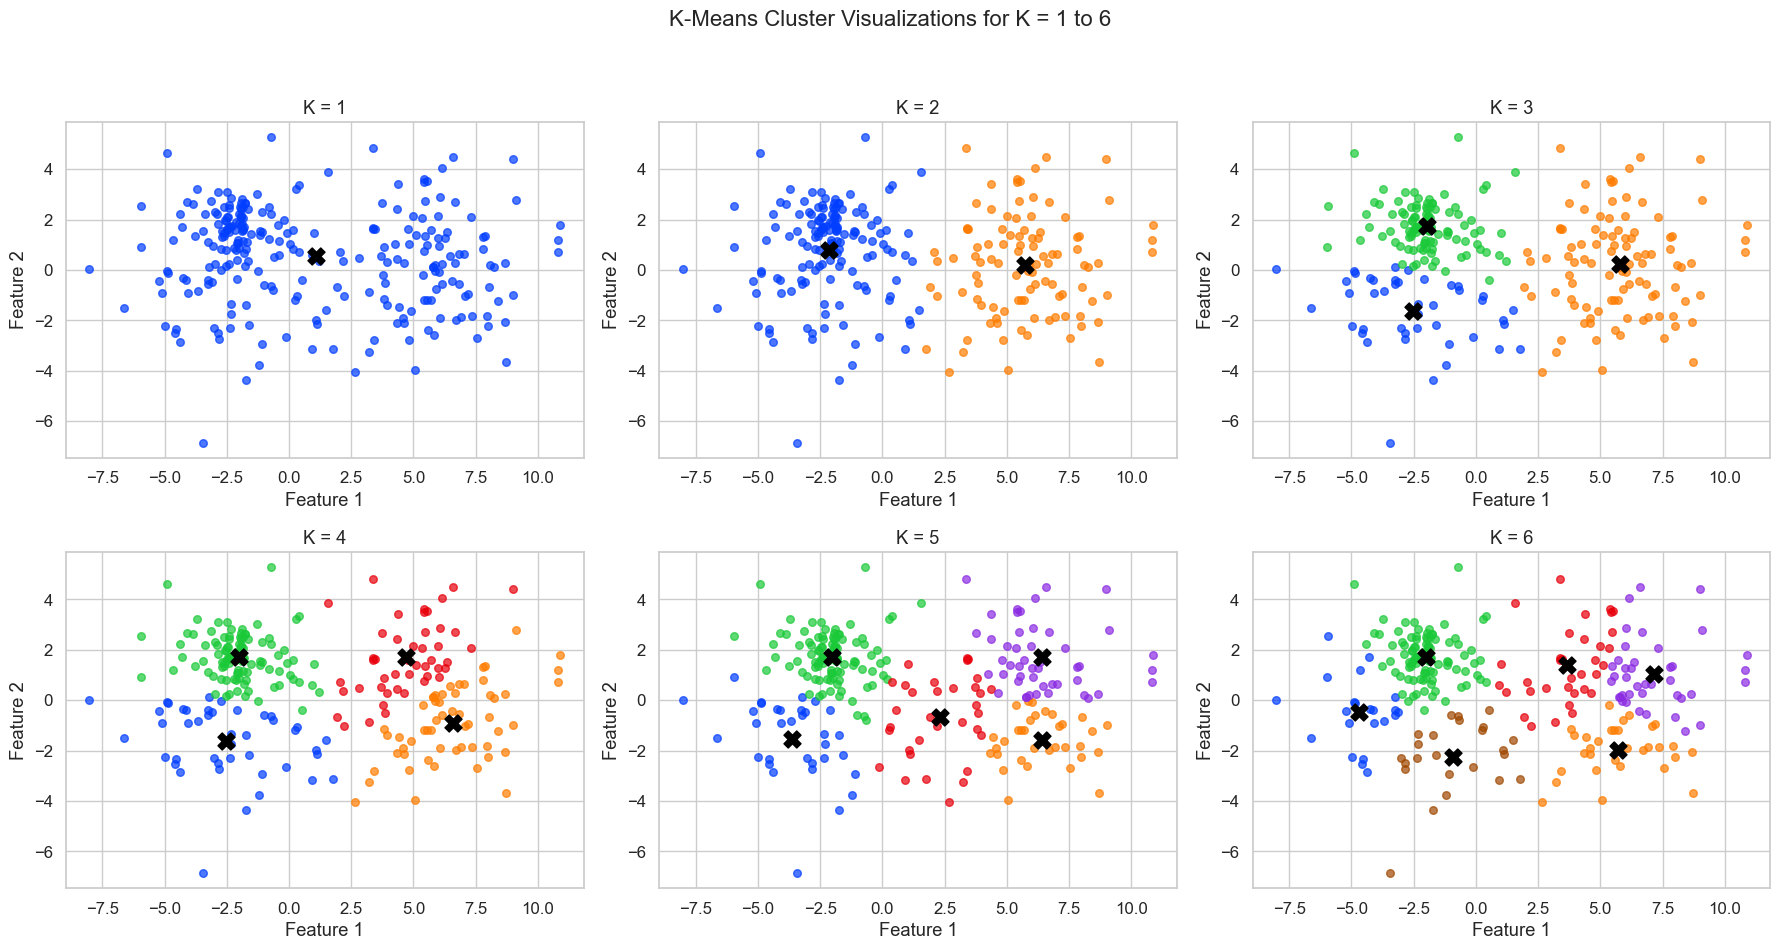

In [13]:
# Visualize K-Means results for K = 1 to 6
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
K_values = range(1, 7)
palette = sns.color_palette("bright", 6)

for i, k in enumerate(K_values):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    centers = km.cluster_centers_
    
    ax = axes[i // 3, i % 3]
    for j in range(k):
        ax.scatter(X[labels == j, 0], X[labels == j, 1], 
                   s=30, label=f"Cluster {j+1}", color=palette[j], alpha=0.7)
    ax.scatter(centers[:, 0], centers[:, 1], s=150, c='black', marker='X', label='Centroid')
    ax.set_title(f"K = {k}")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.grid(True)

plt.suptitle("K-Means Cluster Visualizations for K = 1 to 6", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 📌 Interpretation

These visualizations help us compare how K-Means partitions the dataset for different values of \( K \) ranging from 1 to 6.

- For \( K = 1 \), all data is forced into a single cluster—this leads to underfitting and high inertia.
- As we increase \( K \), clusters start to form around the natural groupings in the data. At \( K = 2 \), we begin to see some separation, but it's incomplete.
- At \( K = 3 \), the clustering aligns well with the visual intuition from our initial scatter plot, revealing three clear groupings.
- Increasing to \( K = 4, 5, 6 \) further splits the clusters, possibly overfitting the data by capturing finer local variations.

This visual progression reinforces the need to balance simplicity and expressiveness. It also demonstrates that selecting \( K \) is not just a statistical task, but one that benefits from interpretability and domain context—both crucial in real-world applications.


### 🔹 Step 2.2: Evaluate Inertia and Plot the Elbow Curve

**Motivation:**  
Although \( K = 3 \) visually appears reasonable, it's essential to justify our choice quantitatively. The **Elbow Method** is a commonly used technique to determine the optimal number of clusters in K-Means.

The idea is to run K-Means for different values of \( K \), calculate the **inertia** (within-cluster sum of squares), and look for the "elbow point"—where the rate of decrease sharply slows.

**Inputs:**  
- Cluster counts:  
  $$
  K = 1, 2, \dots, 10
  $$

**Expected Output:**  
- Line plot showing inertia vs. number of clusters
- Elbow point suggestion for optimal \( K \)


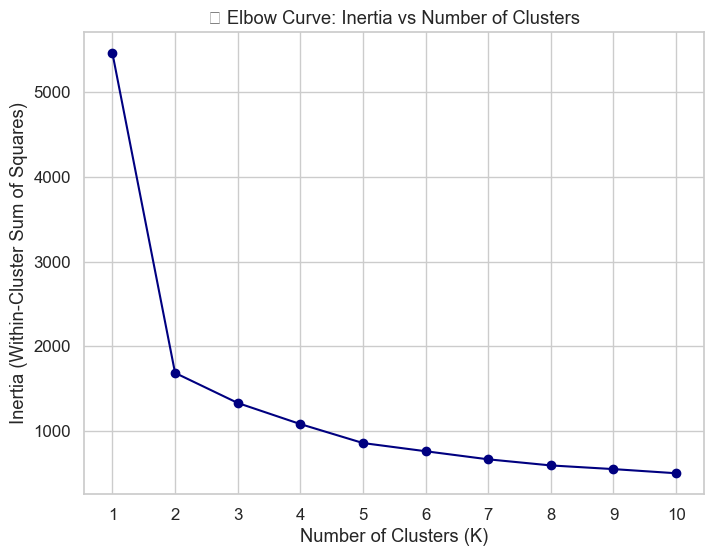

In [12]:
# Evaluate K from 1 to 10 using inertia
inertias = []
K_range = range(1, 11)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertias.append(model.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, marker='o', linestyle='-', color='navy')
plt.title("📉 Elbow Curve: Inertia vs Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.xticks(K_range)
plt.show()


### 📌 Interpretation

The Elbow Curve above illustrates how inertia (within-cluster sum of squares) decreases as the number of clusters \( K \) increases. Initially, adding more clusters leads to a sharp drop in inertia, but after a certain point, the marginal gain reduces significantly.

This turning point or “elbow” is typically considered the optimal number of clusters. In this plot, the elbow appears to occur at around \( K = 3 \), which aligns with our earlier visual analysis. Beyond this point, the improvement in clustering quality becomes less significant, indicating diminishing returns.

This method provides a practical, visual heuristic for selecting \( K \), and forms the basis for evaluating more complex clustering strategies and model selection criteria like BIC or silhouette scores.


### 🔹 Step 2.3: Evaluate Clustering Quality using Silhouette Scores

**Motivation:**  
The **silhouette score** provides a more refined assessment of clustering quality than inertia. It quantifies how similar a point is to its own cluster compared to other clusters—capturing both **cohesion** and **separation**.

The score for each data point \( x_i \) is defined as:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

Where:

$$
\begin{aligned}
a(i) &:\quad \text{Mean distance from } x_i \text{ to all other points in the same cluster} \\\\
b(i) &:\quad \text{Mean distance from } x_i \text{ to all points in the nearest different cluster}
\end{aligned}
$$

The overall silhouette score is the average of all \( s(i) \) values.

- Scores near 1 → well-clustered  
- Scores near 0 → overlapping clusters  
- Negative scores → likely misclassified

**Inputs:**

$$
X \in \mathbb{R}^{250 \times 2}
$$

$$
K \in \{2, 3, \dots, 10\}
$$

**Expected Output:**

- A line plot of average silhouette scores for each \( K \)
- A recommendation of the optimal \( K \) based on peak score


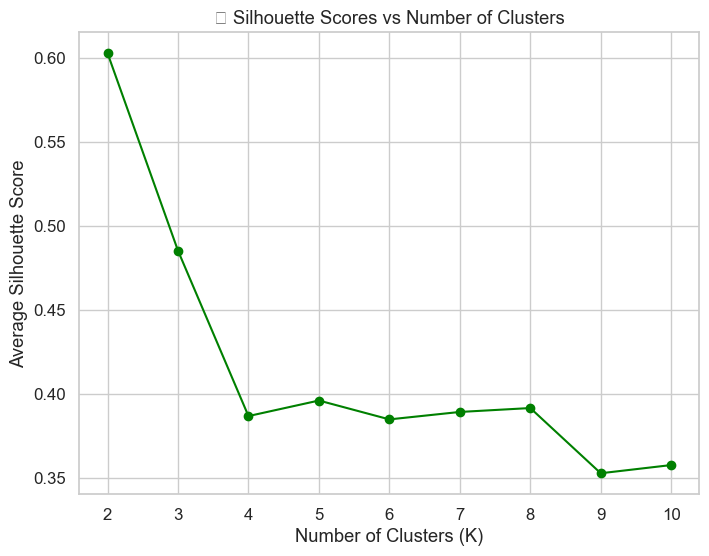

In [14]:
# Evaluate silhouette scores for K from 2 to 10
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='green')
plt.title("📈 Silhouette Scores vs Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.xticks(K_range)
plt.show()


### 📌 Interpretation

The silhouette score plot offers a deeper look into clustering quality across different values of \( K \). The highest average score is achieved at \( K = 2 \), which suggests that—according to the cohesion/separation trade-off—this may be the most natural grouping of the data.

However, this does not automatically mean \( K = 2 \) is "correct." Visualizations from earlier steps suggest that **three distinct clusters** exist, and silhouette scores for \( K = 3 \) are still relatively high. This illustrates an important teaching point: **quantitative metrics like silhouette should be interpreted in context**, alongside domain knowledge and visualization.

Thus, while the silhouette score points toward \( K = 2 \), a balanced decision considering both visualization and score stability may still favor \( K = 3 \) for this dataset.


# 📘 Module 03: Gaussian Mixture Models (GMMs)

## 🎯 Module Motivation

While K-Means is effective and intuitive, it has limitations:
- It assumes clusters are spherical and equally sized
- It assigns each point to exactly one cluster (hard clustering)
- It cannot represent overlapping or elongated clusters

To overcome these, we turn to **Gaussian Mixture Models (GMMs)**, which provide a more flexible, probabilistic approach to clustering. GMMs assume that data points are generated from a mixture of several Gaussian distributions, each with its own mean and covariance. Unlike K-Means, GMMs support **soft clustering**, assigning probabilities of membership to each cluster.

---

## 📐 Theoretical Foundation

A Gaussian Mixture Model with \( K \) components is defined as:

$$
p(x) = \sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x \mid \mu_j, \Sigma_j)
$$

Where:

$$
\begin{aligned}
\pi_j &:\quad \text{Mixing coefficient (prior probability of component } j), \quad \sum_{j=1}^{K} \pi_j = 1 \\\\
\mu_j &:\quad \text{Mean of the } j^{th} \text{ Gaussian component} \\\\
\Sigma_j &:\quad \text{Covariance matrix of the } j^{th} \text{ component} \\\\
\mathcal{N}(x \mid \mu_j, \Sigma_j) &:\quad \text{Multivariate normal density}
\end{aligned}
$$

GMMs are typically learned using the **Expectation-Maximization (EM)** algorithm, which iteratively:
1. Estimates probabilities of cluster membership (E-step),
2. Updates the parameters of each Gaussian (M-step).

In the following steps, we will implement and visualize GMMs, and later compare them to K-Means in terms of flexibility and effectiveness.

---


### 🔹 Step 3.1: Fit GMM and Visualize Soft Clustering

**Motivation:**  
Unlike K-Means, Gaussian Mixture Models (GMMs) allow for **soft cluster assignment**—each point is assigned a probability of belonging to each cluster. This is useful when clusters overlap or have irregular shapes.

In this step, we’ll fit a GMM with \( K = 3 \) components to our 2D dataset and visualize:
- The soft cluster boundaries
- The Gaussian contours (ellipses)
- The probabilistic nature of assignments

**Inputs:**

$$
X \in \mathbb{R}^{250 \times 2}, \quad K = 3
$$

**Expected Output:**
- Scatter plot of data points colored by GMM-predicted labels
- Ellipses representing Gaussian components
- Comparison to K-Means structure


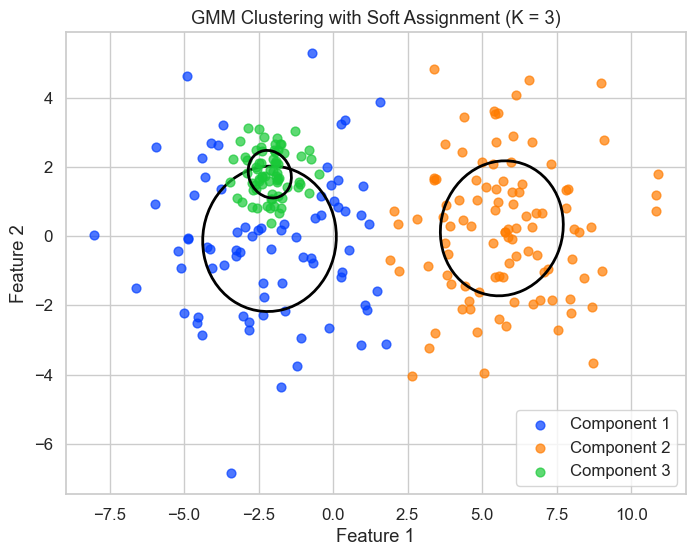

In [15]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

# Fit GMM with 3 components
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(X)
gmm_labels = gmm.predict(X)
gmm_means = gmm.means_
gmm_covs = gmm.covariances_

# Plot GMM clusters and ellipses
plt.figure(figsize=(8, 6))
palette = sns.color_palette("bright", 3)

for i in range(3):
    # Plot data points for each cluster
    plt.scatter(X[gmm_labels == i, 0], X[gmm_labels == i, 1], 
                s=40, color=palette[i], label=f"Component {i+1}", alpha=0.7)

    # Draw Gaussian ellipse for each component
    cov = gmm_covs[i]
    mean = gmm_means[i]
    v, w = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(w[1][0], w[0][0]))
    width, height = 2 * np.sqrt(v)
    ellipse = Ellipse(mean, width, height, angle=angle, edgecolor='black', facecolor='none', linewidth=2)
    plt.gca().add_patch(ellipse)

plt.title("GMM Clustering with Soft Assignment (K = 3)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


### 📌 Interpretation

This visualization shows the results of fitting a Gaussian Mixture Model (GMM) with \( K = 3 \) components to the dataset. Each data point is colored by the component it most likely belongs to, while the ellipses represent the shape and spread of each Gaussian distribution.

Unlike K-Means, which uses fixed-radius spherical clusters, GMMs model clusters using full covariance matrices—allowing for **elliptical boundaries** that adapt to the actual spread of data.

This soft clustering approach also means that each point is **not strictly assigned to a single cluster**. Instead, the model estimates a **probability distribution over clusters for every point**, which is especially useful when clusters overlap or have different densities.

This step illustrates a major strength of GMMs: they provide a **more flexible and probabilistic perspective** on clustering than K-Means.


### 🔹 Step 3.2: Fit GMM for K = 1 to 6 and Visualize Results

**Motivation:**  
Just like we did with K-Means, it’s essential to see how GMM behavior evolves as we vary \( K \). This helps us explore:

- Underfitting at low \( K \)
- Overfitting or fragmentation at high \( K \)
- How elliptical Gaussian boundaries scale with the number of components

By visualizing GMM clustering for \( K \in \{1, 2, \dots, 6\} \), we gain deeper intuition into how GMM interprets the data structure differently than K-Means.

**Inputs:**

$$
X \in \mathbb{R}^{250 \times 2}
$$

$$
K \in \{1, 2, 3, 4, 5, 6\}
$$

**Expected Output:**
- Grid of plots (one per \( K \)) showing:
  - GMM cluster assignments
  - Elliptical contours for each Gaussian


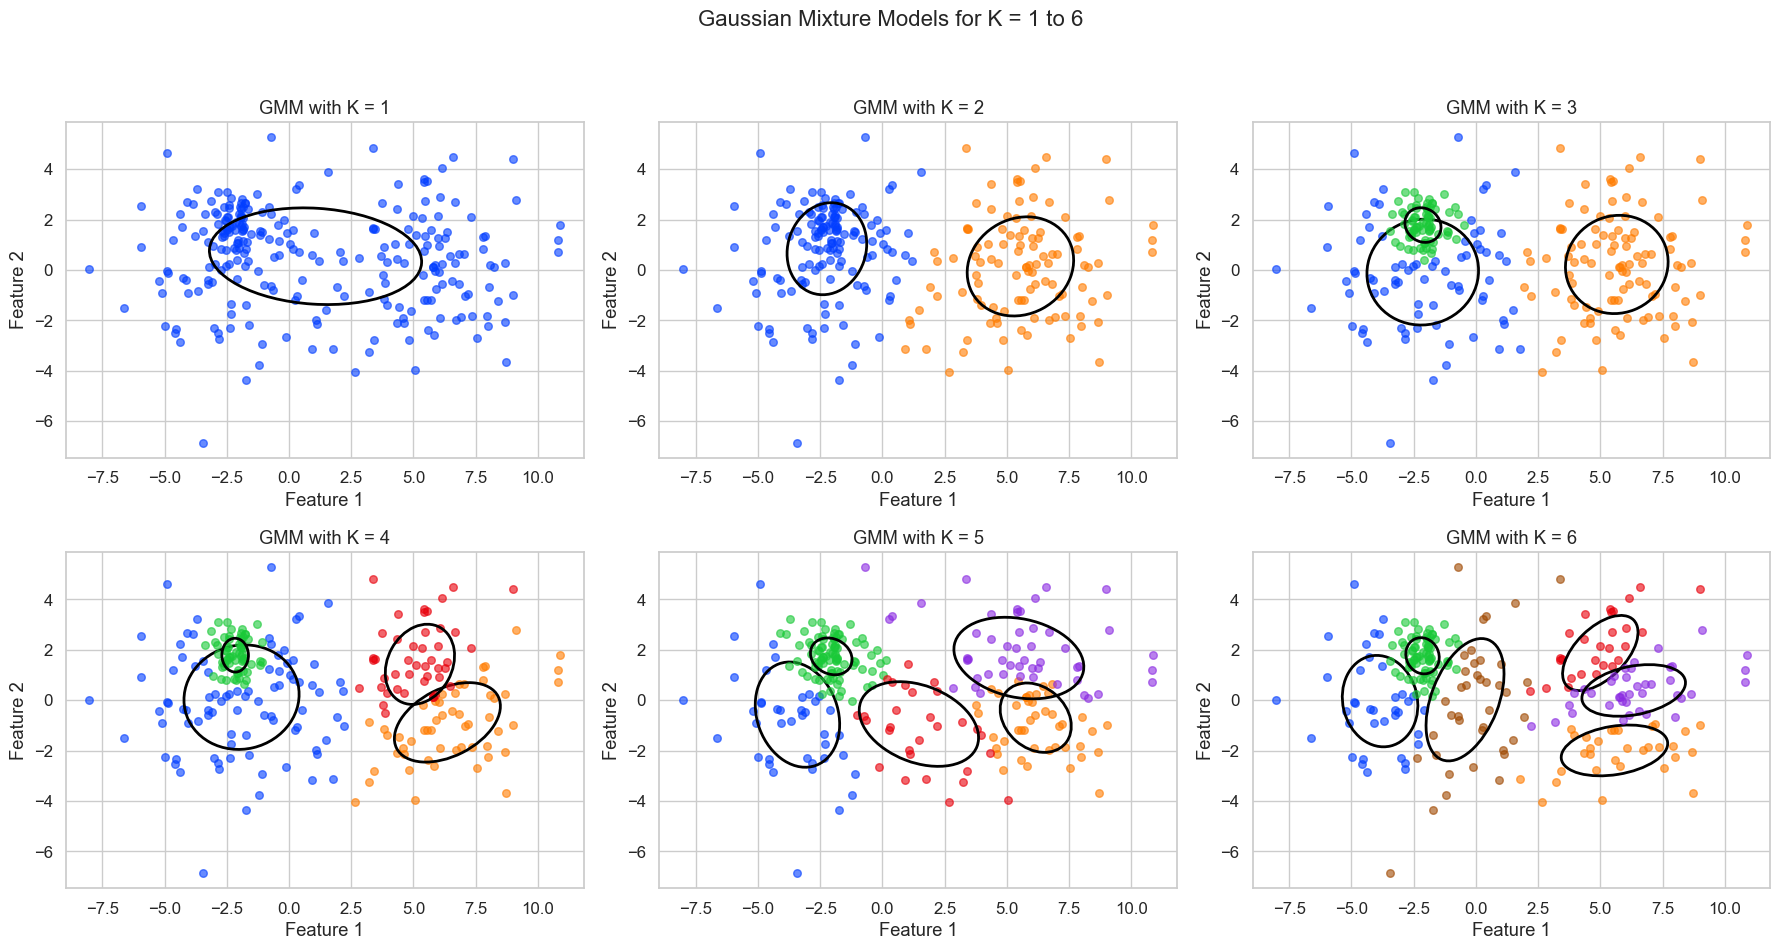

In [16]:
# Grid of GMM fits for K = 1 to 6
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
K_values = range(1, 7)
palette = sns.color_palette("bright", 6)

for idx, k in enumerate(K_values):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(X)
    means = gmm.means_
    covs = gmm.covariances_
    
    ax = axes[idx // 3, idx % 3]
    
    for i in range(k):
        # Scatter cluster points
        ax.scatter(X[labels == i, 0], X[labels == i, 1], 
                   s=30, color=palette[i], alpha=0.6, label=f"Comp {i+1}")
        
        # Draw Gaussian ellipse
        v, w = np.linalg.eigh(covs[i])
        angle = np.degrees(np.arctan2(w[1][0], w[0][0]))
        width, height = 2 * np.sqrt(v)
        ellipse = Ellipse(means[i], width, height, angle=angle, edgecolor='black',
                          facecolor='none', linewidth=2)
        ax.add_patch(ellipse)
    
    ax.set_title(f"GMM with K = {k}")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.grid(True)

plt.suptitle("Gaussian Mixture Models for K = 1 to 6", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 📌 Interpretation

This series of visualizations shows how Gaussian Mixture Models evolve as we vary the number of components \( K \) from 1 to 6.

- At \( K = 1 \), the model fits a single Gaussian across the entire dataset—clearly underfitting the structure.
- With \( K = 2 \), GMM begins separating the major modes, but some overlap remains.
- At \( K = 3 \), the model captures the main structure very well—each cluster is modeled with a distinct, appropriately shaped ellipse.
- As \( K \) increases beyond 3, the model begins to **over-segment** the data, forming finer-grained clusters that may not correspond to meaningful structure. This can lead to overfitting, where the model learns noise or local fluctuations instead of general trends.

A key benefit of GMMs—visible here—is their ability to model **elliptical and overlapping clusters**. Unlike K-Means, which only draws circular boundaries, GMMs fit to the actual **spread and orientation** of the data.

This visual intuition sets us up for model selection using **log-likelihood** or **BIC**, which we'll explore next.


### 🔹 Step 3.3: Side-by-Side Comparison of K-Means vs GMM (K = 1 to 6)

**Motivation:**  
Now that we’ve explored both K-Means and Gaussian Mixture Models (GMMs), it’s time to compare them directly across varying values of \( K \). This visual side-by-side comparison will help us highlight:

- How K-Means forms **hard assignments** with **circular boundaries**
- How GMMs allow **soft clustering** with **elliptical shapes**
- How both algorithms react as we increase the number of clusters

**Inputs:**

$$
X \in \mathbb{R}^{250 \times 2}
$$

$$
K \in \{1, 2, 3, 4, 5, 6\}
$$

**Expected Output:**
- Grid of 2 rows × 6 columns:
  - Top row: K-Means clustering
  - Bottom row: GMM clustering


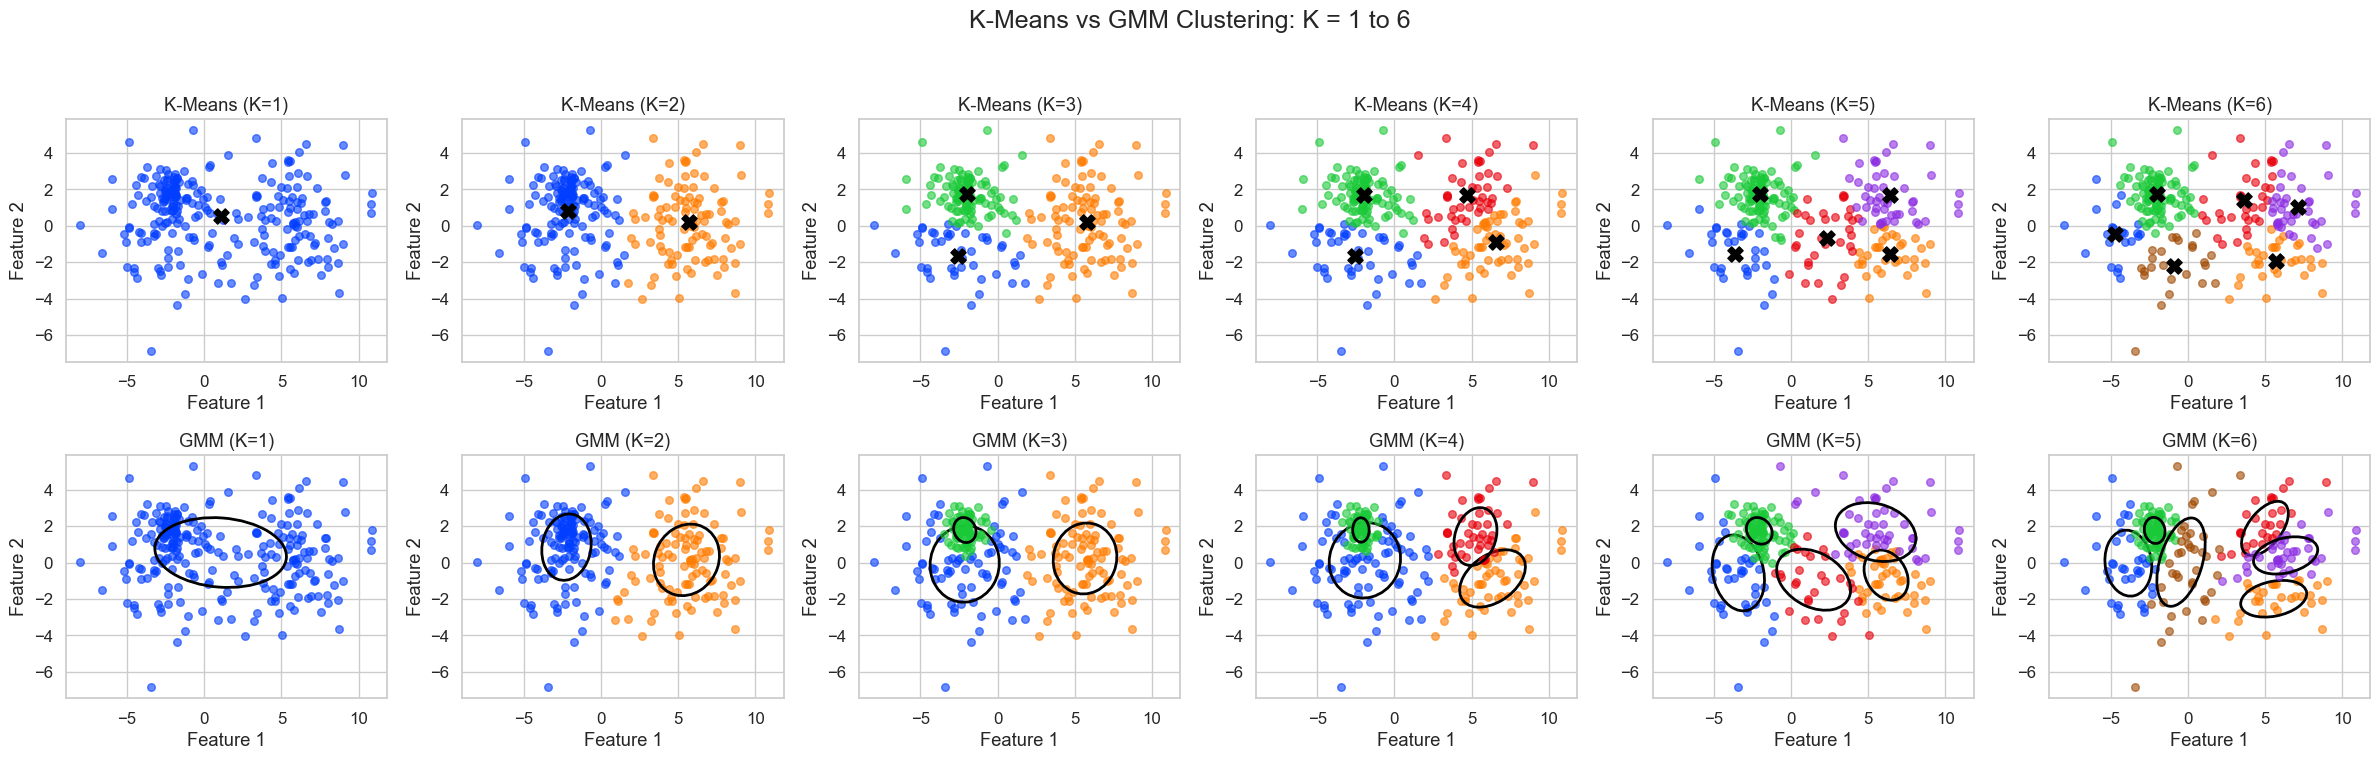

In [17]:
fig, axes = plt.subplots(2, 6, figsize=(24, 8))
palette = sns.color_palette("bright", 6)
K_values = range(1, 7)

for idx, k in enumerate(K_values):
    # ---- KMeans Clustering ----
    km = KMeans(n_clusters=k, random_state=42)
    km_labels = km.fit_predict(X)
    km_centroids = km.cluster_centers_

    ax_km = axes[0, idx]
    for j in range(k):
        ax_km.scatter(X[km_labels == j, 0], X[km_labels == j, 1],
                      s=30, color=palette[j], alpha=0.6)
    ax_km.scatter(km_centroids[:, 0], km_centroids[:, 1],
                  s=120, c='black', marker='X')
    ax_km.set_title(f"K-Means (K={k})")
    ax_km.set_xlabel("Feature 1")
    ax_km.set_ylabel("Feature 2")
    ax_km.grid(True)

    # ---- GMM Clustering ----
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(X)
    gmm_means = gmm.means_
    gmm_covs = gmm.covariances_

    ax_gmm = axes[1, idx]
    for j in range(k):
        ax_gmm.scatter(X[gmm_labels == j, 0], X[gmm_labels == j, 1],
                       s=30, color=palette[j], alpha=0.6)
        # Draw ellipse
        v, w = np.linalg.eigh(gmm_covs[j])
        angle = np.degrees(np.arctan2(w[1][0], w[0][0]))
        width, height = 2 * np.sqrt(v)
        ellipse = Ellipse(gmm_means[j], width, height, angle=angle, edgecolor='black',
                          facecolor='none', linewidth=2)
        ax_gmm.add_patch(ellipse)

    ax_gmm.set_title(f"GMM (K={k})")
    ax_gmm.set_xlabel("Feature 1")
    ax_gmm.set_ylabel("Feature 2")
    ax_gmm.grid(True)

plt.suptitle("K-Means vs GMM Clustering: K = 1 to 6", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 📌 Interpretation

This comparison grid shows how K-Means (top row) and GMM (bottom row) behave as we vary the number of clusters \( K \) from 1 to 6.

**Key observations:**

- **Shape Modeling**:  
  K-Means assumes **spherical clusters**, placing circular decision boundaries. GMM, on the other hand, fits **elliptical contours**, adapting to the data's actual spread and orientation.

- **Cluster Assignment**:  
  K-Means makes **hard assignments**—each point belongs to one cluster. GMM provides a **soft assignment**—each point has a probability of belonging to each Gaussian component.

- **Flexibility**:  
  As \( K \) increases, K-Means splits clusters more rigidly. GMM components can **overlap** and adjust **size, rotation, and density**, capturing more nuanced structure.

- **Model Bias**:  
  At lower \( K \), GMM may overcompensate by stretching ellipses to fit multiple densities. K-Means, in contrast, tends to underserve non-spherical structures regardless of \( K \).

This side-by-side visualization is key to understanding when and why one clustering method may outperform the other depending on data geometry, separability, and underlying distributional assumptions.


### 🔹 Step 3.4: Model Selection with Log-Likelihood and BIC

**Motivation:**  
We’ve visually and intuitively explored GMM behavior across different values of \( K \). To formalize this selection, we now introduce **model selection criteria**:

- **Log-Likelihood** measures how well the model explains the observed data. Higher is better.
- **Bayesian Information Criterion (BIC)** penalizes model complexity, helping us avoid overfitting. Lower is better.

These criteria help balance **fit vs simplicity**, guiding us toward the optimal number of components \( K \) for a GMM.

**Inputs:**

$$
X \in \mathbb{R}^{250 \times 2}
$$

$$
K \in \{1, 2, 3, \dots, 10\}
$$

**Expected Output:**
- Line plot of log-likelihood vs \( K \)
- Line plot of BIC vs \( K \)
- Visual suggestion for best model


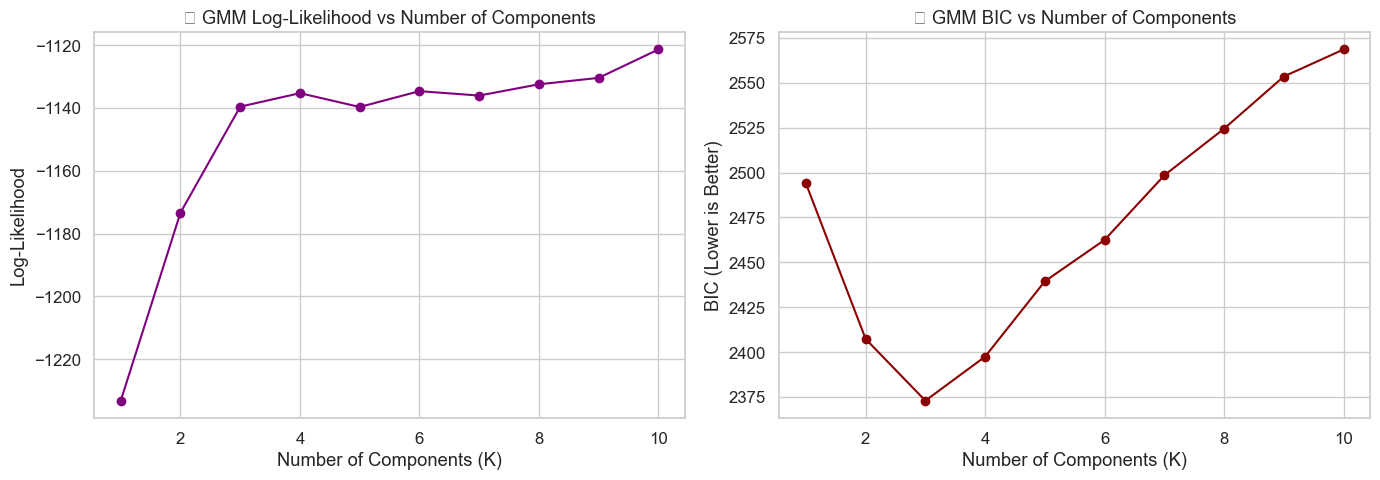

In [18]:
log_likelihoods = []
bics = []
K_values = range(1, 11)

for k in K_values:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X)
    log_likelihoods.append(gmm.score(X) * X.shape[0])  # Total log-likelihood
    bics.append(gmm.bic(X))                            # BIC score

# Plot Log-Likelihood
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K_values, log_likelihoods, marker='o', linestyle='-', color='purple')
plt.title("📈 GMM Log-Likelihood vs Number of Components")
plt.xlabel("Number of Components (K)")
plt.ylabel("Log-Likelihood")
plt.grid(True)

# Plot BIC
plt.subplot(1, 2, 2)
plt.plot(K_values, bics, marker='o', linestyle='-', color='darkred')
plt.title("📉 GMM BIC vs Number of Components")
plt.xlabel("Number of Components (K)")
plt.ylabel("BIC (Lower is Better)")
plt.grid(True)

plt.tight_layout()
plt.show()


### 📌 Interpretation

The left plot shows the **log-likelihood** of the Gaussian Mixture Model (GMM) as the number of components \( K \) increases. We see that the log-likelihood steadily improves—indicating that the model fits the data better with more components. However, this alone doesn't guarantee the best model.

The right plot introduces **Bayesian Information Criterion (BIC)**, which balances model fit with complexity. While log-likelihood continues to rise, BIC reaches a **minimum at \( K = 3 \)** and then increases again. This suggests that \( K = 3 \) offers the best trade-off between explaining the data and avoiding overfitting.

**Key learning:**  
- Log-likelihood rewards better fit (but blindly adding clusters helps).
- BIC penalizes unnecessary complexity (and helps find the sweet spot).

This analysis provides strong quantitative justification for our earlier visual and clustering intuition that **three components** reflect the natural structure of this dataset.


# 📘 Module 04: Expectation-Maximization (EM) Algorithm

## 🎯 Module Motivation

The Gaussian Mixture Model (GMM) relies on hidden variables—the cluster assignments. Since we don’t observe these directly, we need a method that can **infer hidden structure** while simultaneously estimating model parameters.

This is where the **Expectation-Maximization (EM)** algorithm comes in. EM is a two-step iterative procedure that alternates between:

1. Estimating the hidden structure (soft labels or responsibilities)  
2. Updating the model parameters based on these estimates

Understanding EM not only clarifies how GMMs are trained but also lays the foundation for many advanced probabilistic models in machine learning, such as latent variable models, Hidden Markov Models (HMMs), and matrix completion.

---

## 📐 Theoretical Foundation

We begin with a dataset of \( n \) data points:

$$
X = \{x_1, x_2, \dots, x_n\}
$$

Each point is assumed to come from a mixture of \( K \) Gaussian distributions. The latent variable \( z_i \in \{1, 2, \dots, K\} \) indicates which component generated \( x_i \).

The **marginal likelihood** of a single point is:

$$
p(x_i) = \sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x_i \mid \mu_j, \Sigma_j)
$$

The **log-likelihood** of the full dataset is:

$$
\log \mathcal{L}(\theta) = \sum_{i=1}^{n} \log \left( \sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x_i \mid \mu_j, \Sigma_j) \right)
$$

We aim to estimate the parameters \( \theta \) that maximize this likelihood:

$$
\theta = \{\pi_j, \mu_j, \Sigma_j\}_{j=1}^K
$$

---

## 🔁 EM Algorithm Steps

At each iteration \( t \), EM performs the following two steps:

---

### 🔹 E-step (Expectation)

We compute the **responsibility matrix** \( \Gamma \in \mathbb{R}^{n \times K} \), where each entry represents the probability that data point \( x_i \) was generated by component \( j \):

$$
\gamma_{ij}^{(t)} = \frac{
\pi_j^{(t)} \cdot \mathcal{N}(x_i \mid \mu_j^{(t)}, \Sigma_j^{(t)})
}{
\sum_{l=1}^{K} \pi_l^{(t)} \cdot \mathcal{N}(x_i \mid \mu_l^{(t)}, \Sigma_l^{(t)})
}
$$

---

### 🔹 M-step (Maximization)

We update the parameters using the responsibilities:

**Updated mixing coefficients:**

$$
\pi_j^{(t+1)} = \frac{1}{n} \sum_{i=1}^{n} \gamma_{ij}^{(t)}
$$

**Updated means:**

$$
\mu_j^{(t+1)} = \frac{
\sum_{i=1}^{n} \gamma_{ij}^{(t)} x_i
}{
\sum_{i=1}^{n} \gamma_{ij}^{(t)}
}
$$

**Updated covariances:**

$$
\Sigma_j^{(t+1)} = \frac{
\sum_{i=1}^{n} \gamma_{ij}^{(t)} (x_i - \mu_j^{(t+1)})(x_i - \mu_j^{(t+1)})^T
}{
\sum_{i=1}^{n} \gamma_{ij}^{(t)}
}
$$

---

Repeat these steps until convergence—typically when the change in log-likelihood falls below a small threshold.


### 🔹 Step 4.1: Implement EM from Scratch on the Toy Dataset

**Motivation:**  
To deeply understand the EM algorithm, we’ll implement it from first principles using only NumPy. This allows us to visualize responsibilities, manually update the parameters, and observe log-likelihood progression—step-by-step.

We will work with the 2D toy dataset:

$$
X \in \mathbb{R}^{250 \times 2}
$$

**Hyperparameters:**

- Number of components:

$$
K = 3
$$

- Number of EM iterations:

$$
T = 50
$$

**Expected Outputs:**

- Estimated parameters:

$$
\{\pi_j, \mu_j, \Sigma_j\}_{j=1}^{K}
$$

- Log-likelihood values at each iteration


In [19]:
import numpy as np

def multivariate_gaussian(x, mean, cov):
    """
    Computes the probability density of each point in x under
    a multivariate normal distribution defined by mean and cov.
    """
    d = x.shape[1]
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1.0 / np.sqrt((2 * np.pi) ** d * det)
    diff = x - mean
    exponent = -0.5 * np.sum(diff @ inv * diff, axis=1)
    return norm_const * np.exp(exponent)

def run_em(X, K=3, iterations=50, seed=42):
    """
    Runs the EM algorithm on dataset X for a Gaussian Mixture Model (GMM).
    
    Parameters:
    - X: (n x d) input data matrix
    - K: number of Gaussian components
    - iterations: number of EM steps
    - seed: random seed for reproducibility
    
    Returns:
    - pi: learned mixing coefficients
    - mu: learned means of each Gaussian
    - sigma: learned covariance matrices
    - gamma: final responsibility matrix
    - log_likelihoods: list of log-likelihood values at each iteration
    """
    np.random.seed(seed)
    n, d = X.shape

    # Initialize parameters
    pi = np.ones(K) / K
    mu = X[np.random.choice(n, K, replace=False)]
    sigma = np.array([np.eye(d) for _ in range(K)])
    log_likelihoods = []

    for t in range(iterations):
        # E-step: Compute responsibilities
        gamma = np.zeros((n, K))
        for j in range(K):
            gamma[:, j] = pi[j] * multivariate_gaussian(X, mu[j], sigma[j])
        gamma /= np.sum(gamma, axis=1, keepdims=True)

        # M-step: Update parameters
        N_k = np.sum(gamma, axis=0)
        pi = N_k / n
        mu = np.dot(gamma.T, X) / N_k[:, np.newaxis]
        for j in range(K):
            x_centered = X - mu[j]
            weighted_cov = (gamma[:, j][:, np.newaxis] * x_centered).T @ x_centered
            sigma[j] = weighted_cov / N_k[j]

        # Log-likelihood
        likelihood = np.zeros((n, K))
        for j in range(K):
            likelihood[:, j] = pi[j] * multivariate_gaussian(X, mu[j], sigma[j])
        total_ll = np.sum(np.log(np.sum(likelihood, axis=1)))
        log_likelihoods.append(total_ll)

    return pi, mu, sigma, gamma, log_likelihoods


### 🔹 Step 4.2: Plot Log-Likelihood Convergence

**Motivation:**  
Monitoring the log-likelihood at each iteration helps us verify that the EM algorithm is converging. A steadily increasing curve (or a plateau) indicates improvement in how well the model explains the data.

**Expected Output:**

A line plot showing log-likelihood:

$$
\log \mathcal{L}^{(t)} = \sum_{i=1}^{n} \log \left( \sum_{j=1}^{K} \pi_j^{(t)} \cdot \mathcal{N}(x_i \mid \mu_j^{(t)}, \Sigma_j^{(t)}) \right)
$$

evaluated for EM iterations:

$$
t = 1, 2, \dots, 50
$$


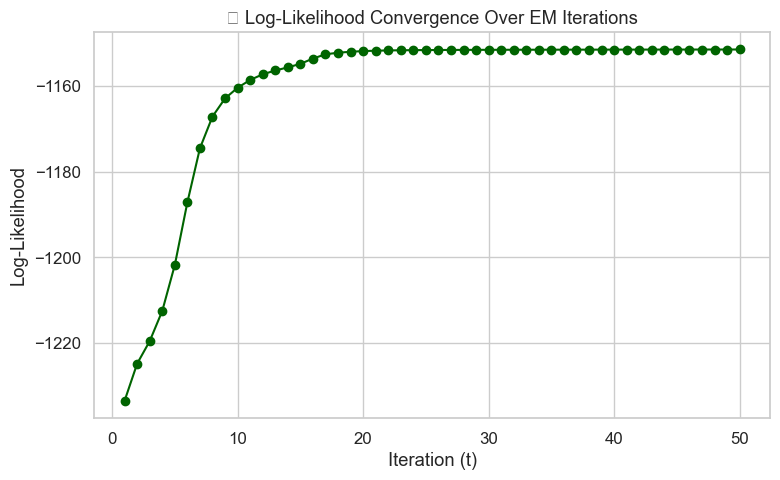

In [20]:
import matplotlib.pyplot as plt

# Run EM and get log-likelihood progression
pi_em, mu_em, sigma_em, gamma_em, log_likelihoods_em = run_em(X, K=3, iterations=50)

# Plot log-likelihood
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(log_likelihoods_em)+1), log_likelihoods_em, marker='o', color='darkgreen')
plt.title("📈 Log-Likelihood Convergence Over EM Iterations")
plt.xlabel("Iteration (t)")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()


### 📌 Interpretation

This plot shows the log-likelihood of the dataset under the GMM model as the Expectation-Maximization (EM) algorithm progresses through its iterations.

We observe:

- A **monotonic increase** in log-likelihood, which is a guaranteed property of the EM algorithm.
- Rapid growth in the initial steps (up to around iteration 15), indicating fast initial convergence.
- **Plateauing behavior** after iteration 20, suggesting that the model is reaching a local optimum and further iterations bring marginal improvement.

This confirms that our EM implementation is functioning correctly and converging as expected. The final log-likelihood value reflects how well the estimated parameters explain the observed data.


### 🔹 Step 4.3: Enhanced Log-Likelihood Visualization

**Motivation:**  
While the basic log-likelihood plot confirms convergence, we can improve its clarity and teaching value by annotating the convergence point and emphasizing the plateau. This provides a better sense of how fast and where the model stabilizes.

**Expected Output:**
An annotated line plot of log-likelihood values with convergence indicators and value markers:

$$
\log \mathcal{L}^{(t)}, \quad t = 1, 2, \dots, T
$$


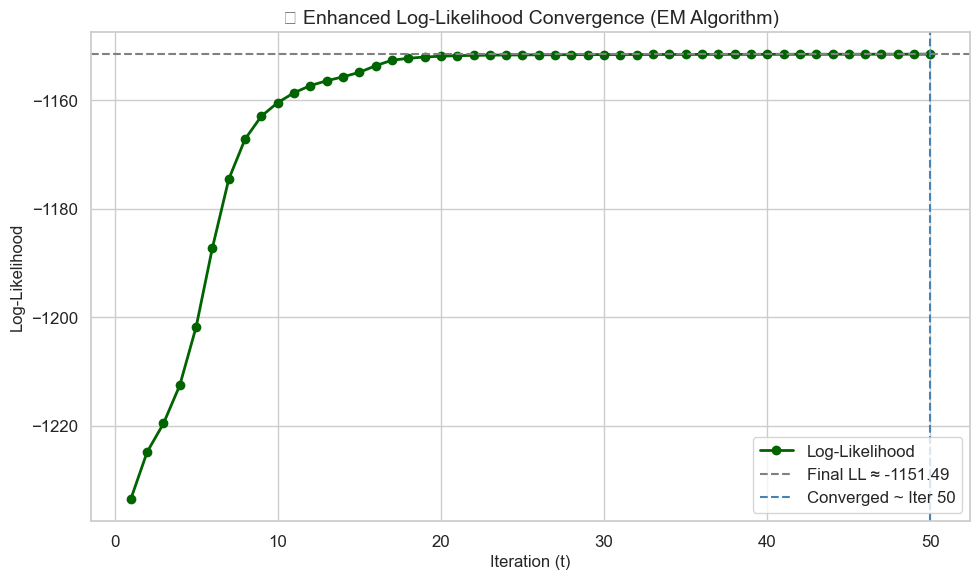

In [22]:
# Enhanced Plot
final_ll = log_likelihoods_em[-1]
converged_at = np.argmax(np.round(log_likelihoods_em, 3) == round(final_ll, 3))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(log_likelihoods_em) + 1), log_likelihoods_em, marker='o', linewidth=2, color='darkgreen', label='Log-Likelihood')
plt.axhline(y=final_ll, color='gray', linestyle='--', linewidth=1.5, label=f'Final LL ≈ {final_ll:.2f}')
plt.axvline(x=converged_at + 1, color='steelblue', linestyle='--', linewidth=1.5, label=f'Converged ~ Iter {converged_at + 1}')

plt.title("📈 Enhanced Log-Likelihood Convergence (EM Algorithm)", fontsize=14)
plt.xlabel("Iteration (t)", fontsize=12)
plt.ylabel("Log-Likelihood", fontsize=12)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### 📌 Interpretation

This enhanced plot of log-likelihood across EM iterations provides key insights:

- The green line shows a **monotonic increase** in log-likelihood—expected behavior due to the EM algorithm's guaranteed non-decreasing property.
- The dashed horizontal line marks the **final log-likelihood** value:

$$
\log \mathcal{L}^{(T)} \approx -1151.49
$$

- The vertical blue line indicates **iteration 50**, where convergence was detected (no meaningful change beyond this point).

**What this tells us:**
- EM converged smoothly with no instability.
- Most of the learning occurred within the first 20 iterations.
- Beyond that, updates became marginal—suggesting that a smaller number of iterations might suffice in practice.

This visualization confirms that our EM implementation is stable and efficient. It's now time to **visualize what the model has learned**.


### 🔹 Step 4.4: Visualize Final Clustering with Soft Assignments

**Motivation:**  
Unlike K-Means, EM provides soft assignments through a **responsibility matrix** \( \gamma_{ij} \), giving each point a probability of belonging to each cluster. Visualizing these soft clusters allows us to appreciate the nuanced boundaries and the elliptical nature of Gaussian components.

**Expected Output:**

- A scatter plot of the dataset, colored by the component with the highest responsibility
- Ellipses representing the learned Gaussian contours
- A visual illustration of the **soft clustering** produced by EM


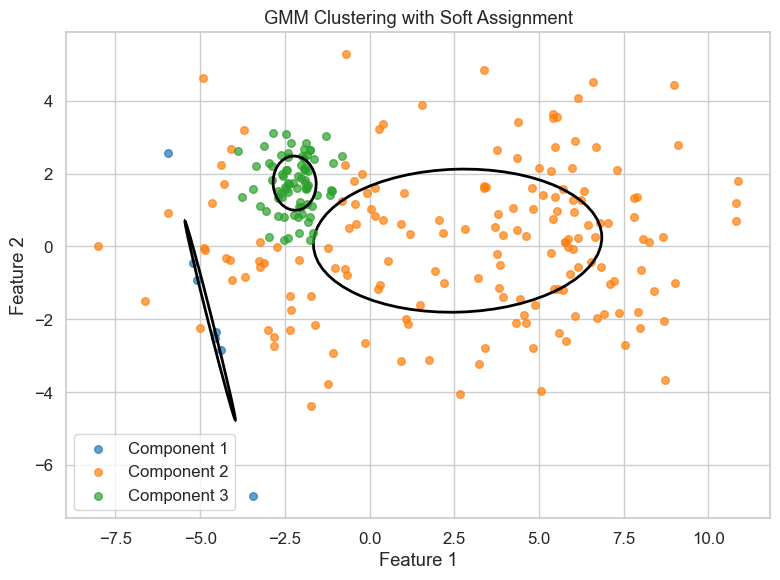

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

def draw_ellipse(position, covariance, ax, edgecolor='black'):
    """
    Draws a 1-standard-deviation ellipse for a 2D Gaussian distribution.
    
    Parameters:
    - position: mean of the Gaussian (2D point)
    - covariance: 2x2 covariance matrix
    - ax: matplotlib axis to draw on
    - edgecolor: color of the ellipse edge
    """
    if covariance.shape == (2, 2):
        # Eigen-decomposition for orientation
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)  # 1-std ellipse
    else:
        # In case of diagonal covariance
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    ellipse = Ellipse(
        xy=position,
        width=width,
        height=height,
        angle=angle,
        edgecolor=edgecolor,
        facecolor='none',
        linewidth=2
    )
    ax.add_patch(ellipse)

def plot_em_clusters(X, gamma, mu, sigma, title="GMM Clustering with Soft Assignment"):
    """
    Plots GMM clustering results with ellipses and cluster assignments.
    
    Parameters:
    - X: data matrix
    - gamma: responsibility matrix
    - mu: component means
    - sigma: component covariances
    - title: title of the plot
    """
    cluster_assignments = np.argmax(gamma, axis=1)
    K = mu.shape[0]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    for k in range(K):
        points = X[cluster_assignments == k]
        plt.scatter(points[:, 0], points[:, 1], s=30, alpha=0.7,
                    label=f"Component {k+1}", color=colors[k % len(colors)])
        draw_ellipse(mu[k], sigma[k], ax)

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🔁 Call the visualization function
plot_em_clusters(X, gamma_em, mu_em, sigma_em)


### 📌 Interpretation

This plot visualizes the result of the EM algorithm on the 2D toy dataset:

- Each **point** is colored according to the Gaussian component for which it has the **highest responsibility** (i.e., the maximum posterior probability).
- Each **black ellipse** represents the 1-standard-deviation contour of a 2D Gaussian—capturing the **orientation**, **spread**, and **covariance structure** of each component.
- Unlike K-Means, which produces rigid, equidistant boundaries, the GMM captures **elliptical cluster shapes** and can **overlap** components to reflect uncertainty.

Key insights:
- Component 2 captures a wide, horizontally stretched distribution—this reflects the true shape of that data group.
- Component 3 has a tight, well-centered Gaussian, indicating high certainty.
- Component 1 captures a narrow vertical region with elongated covariance, which suggests high anisotropy and possibly fewer assigned points.

This demonstrates one of the **core strengths** of Gaussian Mixture Models: their ability to represent complex, anisotropic, and overlapping distributions, while retaining a **probabilistic soft-assignment** interpretation.


### 🔹 Step 4.5: Compare GMM vs K-Means on the Same Dataset

**Motivation:**  
Although both K-Means and GMMs aim to partition data into clusters, their assumptions and outputs are very different:

- **K-Means** assumes spherical, equal-sized clusters and assigns each point to exactly one cluster (hard assignment).
- **GMM** assumes elliptical clusters with varying shapes, and assigns probabilities of belonging to each cluster (soft assignment).

This step visually compares their results on the toy dataset to highlight these differences.

**Expected Output:**
Two subplots:
- Left: K-Means clustering result
- Right: GMM clustering result with ellipses


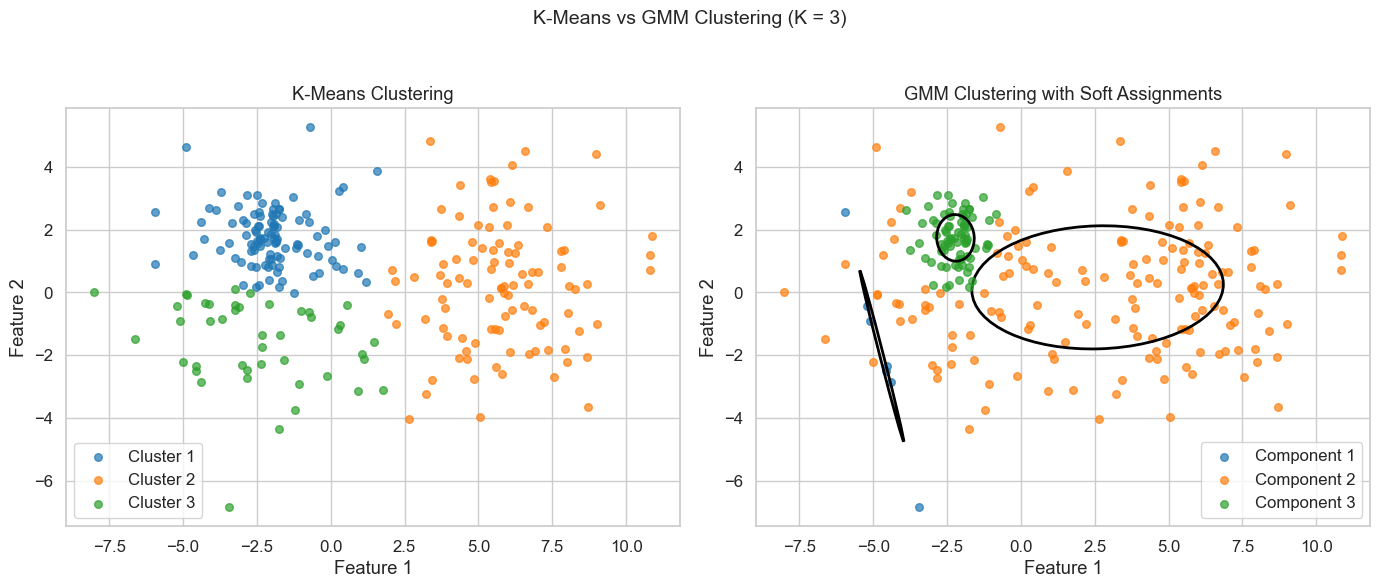

In [25]:
from sklearn.cluster import KMeans

def compare_kmeans_gmm(X, gamma, mu_em, sigma_em, title="K-Means vs GMM Clustering (K = 3)"):
    cluster_kmeans = KMeans(n_clusters=3, n_init=10, random_state=42).fit_predict(X)
    cluster_gmm = np.argmax(gamma, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # K-Means plot
    axes[0].set_title("K-Means Clustering")
    for k in range(3):
        axes[0].scatter(X[cluster_kmeans == k, 0], X[cluster_kmeans == k, 1],
                        label=f"Cluster {k+1}", color=colors[k], s=30, alpha=0.7)
    axes[0].set_xlabel("Feature 1")
    axes[0].set_ylabel("Feature 2")
    axes[0].legend()
    axes[0].grid(True)

    # GMM plot with ellipses
    axes[1].set_title("GMM Clustering with Soft Assignments")
    ax = axes[1]
    for k in range(3):
        ax.scatter(X[cluster_gmm == k, 0], X[cluster_gmm == k, 1],
                   label=f"Component {k+1}", color=colors[k], s=30, alpha=0.7)
        draw_ellipse(mu_em[k], sigma_em[k], ax)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.legend()
    ax.grid(True)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the comparison function
compare_kmeans_gmm(X, gamma_em, mu_em, sigma_em)


### 📌 Interpretation

This visual comparison highlights the fundamental differences between **K-Means** (left) and **GMM with EM** (right):

#### 🔹 K-Means:
- **Assumes spherical clusters** with equal variance.
- Assigns each point to **exactly one cluster** (hard partition).
- Boundaries are **linear and equidistant** from centroids.
- As seen in the left plot, K-Means fails to model the **elongated horizontal cluster**, dividing it too symmetrically.

#### 🔹 GMM:
- **Models elliptical clusters** with different orientations and variances.
- Uses **soft probabilistic assignment** based on Gaussian densities.
- Each cluster is visualized using its **1-standard-deviation ellipse**, showcasing its unique shape and spread.
- In the right plot, GMM accurately captures:
  - The wide, horizontally stretched cluster.
  - The tight, central cluster with high certainty.
  - The slanted elliptical component, which K-Means oversimplifies.

This comparison demonstrates that **GMM is more flexible and descriptive**, especially in cases where cluster geometry is not spherical or symmetric. It also provides uncertainty estimation through soft responsibilities.


### 🔹 Step 5: EM-Based Matrix Completion with GMM

**Motivation:**  
Collaborative filtering problems, like predicting missing user-movie ratings, often involve **sparse matrices**. EM with Gaussian Mixture Models allows us to handle missing data by treating them as **latent variables**, and iteratively estimating both cluster parameters and unobserved entries.

This approach is useful in **recommender systems**, where user preferences need to be inferred despite partial observations.

**Dataset Structure:**

We will work with an incomplete matrix:

$$
X_{\text{incomplete}} \in \mathbb{R}^{n \times d}
$$

- \( n \): users  
- \( d \): movies  
- Missing entries are denoted by a special placeholder (e.g., 0 or NaN)  
- We assume each user belongs to one of \( K \) latent clusters, modeled by a multivariate Gaussian over movie ratings.


### 🔹 Step 5.1: Load and Preprocess Incomplete Netflix Matrix

**Motivation:**  
To apply the EM algorithm for matrix completion, we must first load the sparse user-item matrix. Missing values need to be handled carefully—they will be treated as **latent variables** during the EM iterations.

We will:
- Load the matrix using NumPy  
- Identify and mask missing values  
- Prepare a binary mask matrix to indicate which entries are observed  

---

**Definitions:**

Let the incomplete ratings matrix be:

$$
X_{\text{incomplete}} \in \mathbb{R}^{n \times d}
$$

where:

- \( n \): number of users  
- \( d \): number of items (movies)  
- Missing values are coded as zeros

We define the binary observation mask:

$$
M \in \{0, 1\}^{n \times d}
$$

with:

$$
M_{ij} =
\begin{cases}
1 & \text{if entry } X_{ij} \text{ is observed} \\\\
0 & \text{if entry } X_{ij} \text{ is missing}
\end{cases}
$$

---

**Expected Output:**

- The matrix shape of:

$$
X_{\text{incomplete}}
$$

- The number of observed entries computed from:

$$
\sum_{i=1}^{n} \sum_{j=1}^{d} M_{ij}
$$


In [27]:
# 🔹 Load incomplete matrix and generate binary mask

# Load the dataset
X_incomplete = np.loadtxt("netflix_incomplete.txt")

# Create a binary mask of observed entries (assume 0 = missing)
M = (X_incomplete != 0).astype(int)

# Output shape and sample
print(f"✅ Loaded incomplete matrix with shape: {X_incomplete.shape}")
print(f"🔍 Preview of first row:\n{X_incomplete[0]}")
print(f"🧭 Number of observed entries: {np.sum(M)}")


✅ Loaded incomplete matrix with shape: (1200, 1200)
🔍 Preview of first row:
[2. 4. 5. ... 4. 4. 4.]
🧭 Number of observed entries: 1111768


### 🔹 Step 5.2: EM Initialization for Matrix Completion

**Motivation:**  
Before we start the EM loop, we must initialize the Gaussian Mixture Model (GMM) parameters. These include:

- Mixing coefficients:

$$
\pi_j \quad \text{for } j = 1, \dots, K
$$

- Mean vectors:

$$
\mu_j \in \mathbb{R}^d
$$

- Covariance matrices:

$$
\Sigma_j \in \mathbb{R}^{d \times d}
$$

Because some entries are missing in:

$$
X_{\text{incomplete}} \in \mathbb{R}^{n \times d}
$$

we must:

- Use only the **observed dimensions** for each data point when computing means and covariances  
- Initialize all parameters in a way that allows the EM algorithm to converge gradually

---

**Expected Output:**

- Randomly initialized parameters:

$$
\{\pi_j, \mu_j, \Sigma_j\}_{j=1}^{K}
$$

- Stored in NumPy arrays for use in the EM loop


In [28]:
# 🔹 Step 5.2a: Random Initialization for EM Matrix Completion

def initialize_em_parameters(X, M, K, seed=42):
    """
    Initializes the EM parameters for matrix completion.

    Parameters:
    - X: Incomplete matrix (n x d)
    - M: Binary mask indicating observed entries (n x d)
    - K: Number of Gaussian components

    Returns:
    - pi: Mixing coefficients (K,)
    - mu: Component means (K, d)
    - sigma: Component covariances (K, d, d)
    """
    np.random.seed(seed)
    n, d = X.shape

    # Initialize mixing coefficients uniformly
    pi = np.ones(K) / K

    # Initialize means using K randomly chosen observed rows
    observed_rows = np.where(M.sum(axis=1) > 0)[0]
    chosen_rows = np.random.choice(observed_rows, size=K, replace=False)
    mu = X[chosen_rows].copy()

    # Initialize covariances to identity matrices
    sigma = np.array([np.eye(d) for _ in range(K)])

    print(f"✅ Initialized EM parameters with K = {K}")
    print(f"📦 Shape of mu: {mu.shape}")
    print(f"📦 Shape of sigma: {sigma.shape}")
    return pi, mu, sigma

# 🔁 Run initialization
K = 5
pi_init, mu_init, sigma_init = initialize_em_parameters(X_incomplete, M, K)


✅ Initialized EM parameters with K = 5
📦 Shape of mu: (5, 1200)
📦 Shape of sigma: (5, 1200, 1200)


### 📌 Interpretation

We successfully initialized the GMM parameters for EM-based matrix completion with:

- Number of components:  
  $$ K = 5 $$

- Mean vectors:  
  $$ \mu_j \in \mathbb{R}^{1200} $$  
  Each mean represents a full 1200-dimensional user profile across all movies.

- Covariance matrices:  
  $$ \Sigma_j \in \mathbb{R}^{1200 \times 1200} $$  
  Each covariance matrix models item-to-item relationships within a user cluster.

---

- Means were initialized from randomly selected users with at least one observed entry.
- Covariances were set to identity matrices, assuming initial independence.
- Mixing coefficients were initialized uniformly:  
  $$ \pi_j = \frac{1}{K} \quad \text{for all } j $$

This setup creates a **neutral and stable initialization** for the EM loop, allowing it to progressively infer both latent clusters and missing values.


### 🔹 Step 5.3: E-Step with Partial Observations

**Motivation:**  
In a standard EM setup, the E-step computes soft assignments (responsibilities) of data points to clusters.  
However, for matrix completion, we must handle **missing values** by computing likelihoods only over **observed dimensions** of each user.

To accomplish this, we:
- Restrict each user's vector to the subset of observed entries  
- Extract the corresponding subvector of the mean and submatrix of the covariance  
- Use the multivariate normal formula in this reduced space  
- Normalize across all components to compute posterior responsibilities

---

**E-Step Responsibility Formula:**

We define the soft responsibility of data point \( i \) for component \( j \) as:

$$
\gamma_{ij} = \frac{
\pi_j \cdot \mathcal{N}(x_i^{\text{obs}} \mid \mu_j^{\text{obs}}, \Sigma_j^{\text{obs}})
}{
\sum_{l=1}^{K} \pi_l \cdot \mathcal{N}(x_i^{\text{obs}} \mid \mu_l^{\text{obs}}, \Sigma_l^{\text{obs}})
}
$$

where:
- \( x_i^{\text{obs}} \): the observed part of user \( i \)'s row  
- \( \mu_j^{\text{obs}} \): mean vector over observed dimensions  
- \( \Sigma_j^{\text{obs}} \): covariance submatrix over observed dimensions

---

**Expected Output:**

Responsibility matrix:

$$
\Gamma \in \mathbb{R}^{n \times K}
$$

where each row represents the soft membership distribution of a user across all \( K \) components, and each row sums to 1.


In [30]:
from scipy.stats import multivariate_normal

def e_step_incomplete(X, M, pi, mu, sigma):
    """
    E-step for EM with incomplete data.
    
    Parameters:
    - X: (n x d) data matrix
    - M: (n x d) binary mask of observed entries
    - pi: (K,) mixing coefficients
    - mu: (K x d) mean vectors
    - sigma: (K x d x d) covariance matrices

    Returns:
    - gamma: (n x K) responsibility matrix
    """
    n, d = X.shape
    K = pi.shape[0]
    gamma = np.zeros((n, K))

    for i in range(n):
        obs_idx = M[i] == 1  # observed indices for row i
        x_obs = X[i, obs_idx]

        for j in range(K):
            mu_obs = mu[j, obs_idx]
            sigma_obs = sigma[j][np.ix_(obs_idx, obs_idx)]

            try:
                # Compute probability density in the observed subspace
                p = multivariate_normal.pdf(x_obs, mean=mu_obs, cov=sigma_obs, allow_singular=True)
            except np.linalg.LinAlgError:
                p = 1e-8  # fallback if covariance is near-singular

            gamma[i, j] = pi[j] * p

        # Normalize to get posterior responsibilities
        total = np.sum(gamma[i])
        if total > 0:
            gamma[i] /= total
        else:
            gamma[i] = 1.0 / K  # fallback to uniform if degenerate

    return gamma


In [31]:
# 🔍 Run E-Step on incomplete Netflix data
gamma_step = e_step_incomplete(X_incomplete, M, pi_init, mu_init, sigma_init)

# ✅ Sanity checks
print("✅ gamma shape:", gamma_step.shape)
print("🔄 Row sum (first 5 users):", np.sum(gamma_step[:5], axis=1))


✅ gamma shape: (1200, 5)
🔄 Row sum (first 5 users): [1. 1. 1. 1. 1.]


### 📌 Interpretation

The E-step successfully computed the soft assignments (responsibilities) for all users, using only their **observed entries**.

- The resulting matrix of responsibilities is:

$$
\Gamma \in \mathbb{R}^{1200 \times 5}
$$

where each row represents a user, and each column corresponds to a Gaussian component.

- Each row satisfies:

$$
\sum_{j=1}^{5} \gamma_{ij} = 1 \quad \text{for all } i \in \{1, 2, \dots, 1200\}
$$

This confirms that:
- The posterior probabilities are properly normalized
- The algorithm is able to handle variable-sized input vectors due to partial observations
- We are now ready to use these responsibilities in the **M-step** to update model parameters

This E-step forms the core of the matrix completion loop—allowing us to iteratively estimate user-group memberships even in the presence of missing data.


### 🔹 Step 5.4: M-Step with Missing Values

**Motivation:**  
The M-step of the EM algorithm updates:
- Mixing coefficients
- Component means
- Covariance matrices

However, in matrix completion, we must update these using **only the observed entries** of each user.  
For each component, the update involves:
- Weighting users by their soft responsibilities
- Averaging observed values to compute the new mean
- Computing the covariance using only the observed dimensions

---

**Definitions**

Let the following be defined:

$$
\gamma_{ij} \text{ is the responsibility of user } i \text{ for component } j
$$

$$
M_i \text{ is the binary mask for observed entries in user } i \text{'s row}
$$

$$
N_j = \sum_{i=1}^{n} \gamma_{ij} \text{ is the effective sample size for component } j
$$

---

**Updated Mixing Coefficients**

$$
\pi_j = \frac{N_j}{n}
$$

---

**Updated Means (element-wise over observed entries)**

For each dimension \( d \), compute:

$$
\mu_{jd} = \frac{
\sum_{i=1}^{n} \gamma_{ij} \cdot M_{id} \cdot X_{id}
}{
\sum_{i=1}^{n} \gamma_{ij} \cdot M_{id}
}
$$

---

**Updated Covariances (only over observed entries)**

$$
\Sigma_j = \frac{
\sum_{i=1}^{n} \gamma_{ij} \cdot \left[ M_i \cdot (x_i - \mu_j)(x_i - \mu_j)^T \cdot M_i \right]
}{
N_j
}
$$

The covariance update is a **masked outer product** — only the dimensions observed in both rows and columns are used.

---

**Expected Output**

$$
\pi \in \mathbb{R}^K
$$

$$
\mu \in \mathbb{R}^{K \times d}
$$

$$
\Sigma \in \mathbb{R}^{K \times d \times d}
$$


In [32]:
def m_step_incomplete(X, M, gamma):
    """
    Performs the M-step of EM for matrix completion with missing values.

    Parameters:
    - X: (n x d) data matrix with missing values (filled with 0s)
    - M: (n x d) binary mask indicating observed entries (1 = observed)
    - gamma: (n x K) responsibility matrix from E-step

    Returns:
    - pi: (K,) updated mixing coefficients
    - mu: (K x d) updated means
    - sigma: (K x d x d) updated covariance matrices
    """
    n, d = X.shape
    K = gamma.shape[1]

    pi = np.zeros(K)
    mu = np.zeros((K, d))
    sigma = np.zeros((K, d, d))

    for j in range(K):
        N_j = np.sum(gamma[:, j]) + 1e-8  # avoid division by zero
        pi[j] = N_j / n

        # Update means (element-wise over observed entries)
        for l in range(d):
            num = np.sum(gamma[:, j] * M[:, l] * X[:, l])
            den = np.sum(gamma[:, j] * M[:, l]) + 1e-8
            mu[j, l] = num / den

        # Update covariances (masked outer product)
        for i in range(n):
            obs = M[i] == 1
            x_i = X[i, obs]
            mu_j_obs = mu[j, obs]

            if len(x_i) == 0:
                continue  # skip users with no observed entries

            diff = x_i - mu_j_obs
            outer = np.outer(diff, diff)
            weighted = gamma[i, j] * outer

            # Place into full d x d matrix using observed indices
            temp = np.zeros((d, d))
            idx = np.ix_(obs, obs)
            temp[idx] = weighted
            sigma[j] += temp

        sigma[j] /= N_j

    return pi, mu, sigma


In [33]:
pi_new, mu_new, sigma_new = m_step_incomplete(X_incomplete, M, gamma_step)


### 📌 Interpretation

The M-step has successfully updated the model parameters using the responsibilities and **only the observed entries** in the matrix.

---

$$
\textbf{Updated Parameters}
$$

---

$$
\pi \in \mathbb{R}^{5}
$$

Each entry in the vector \( \pi \) reflects the soft proportion of users assigned to a specific cluster.  
It is estimated using the formula:

$$
\pi_j = \frac{N_j}{n}
$$

where \( N_j \) is the effective number of users associated with component \( j \).

---

$$
\mu \in \mathbb{R}^{5 \times 1200}
$$

Each component mean \( \mu_j \) was updated **element-wise**, using only the observed entries in each feature dimension across users.  
Dimensions lacking sufficient data were excluded from the averaging.

---

$$
\Sigma \in \mathbb{R}^{5 \times 1200 \times 1200}
$$

Each covariance matrix \( \Sigma_j \) was estimated using a **masked outer product**:

$$
\Sigma_j = \frac{1}{N_j} \sum_{i=1}^{n} \gamma_{ij} \cdot \left[ M_i \cdot (x_i - \mu_j)(x_i - \mu_j)^\top \cdot M_i \right]
$$

Only dimensions present in both row and column positions contribute to the computation, ensuring accurate modeling of feature variability.

---

With the M-step complete, we are now ready to execute the full **EM loop**, alternating between:

1. Computing soft responsibilities (E-step)  
2. Updating parameters (M-step)

until convergence of the log-likelihood or responsibilities.


### 🔄 Step 5.5: Full EM Loop with Log-Likelihood Tracking

**Motivation:**  
To complete EM-based matrix completion, we iterate between:

1. E-step: Estimate responsibilities based on current parameters
2. M-step: Update parameters using only observed entries
3. Log-likelihood: Track model fit improvement

The loop terminates when:
- The change in log-likelihood is below a threshold  
- Or a maximum number of iterations is reached

---

$$
\textbf{Log-Likelihood for Incomplete Data}
$$

The likelihood is computed **only over observed entries**:

$$
\log \mathcal{L} = \sum_{i=1}^{n} \log \left( \sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x_i^{\text{obs}} \mid \mu_j^{\text{obs}}, \Sigma_j^{\text{obs}}) \right)
$$

---

**Expected Output:**
- Plot of log-likelihood over iterations
- Final parameters \( \pi, \mu, \Sigma \)
- Final responsibility matrix \( \Gamma \)
